In [5]:
from sklearn import datasets
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [59]:
from datetime import datetime

In [67]:
t0 = datetime.now()

In [75]:
t1 = datetime.now()
del_t = t1-t0
print("{}".format(del_t))

0:00:59.925370


In [6]:
digits = datasets.load_digits()

In [7]:
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

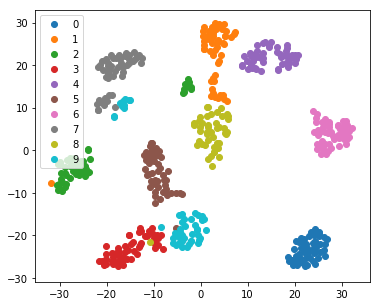

In [15]:
""" Training Data """
X = digits.data[:500]
X_2d = tsne.fit_transform(X)
y = digits.target[:500]

target_ids = range(len(digits.target_names))
plt.figure(figsize=(6, 5))
for i, label in zip(target_ids, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=label)
plt.legend()
plt.show()

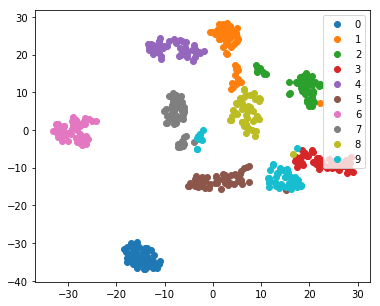

In [16]:
""" Training data Scaled """
Xs_2d = tsne.fit_transform(Xs)
plt.figure(figsize=(6, 5))
for i, label in zip(target_ids, digits.target_names):
    plt.scatter(Xs_2d[y == i, 0], Xs_2d[y == i, 1], label=label)
plt.legend()
plt.show()

In [18]:
""" Scaling the data """
scaler = MinMaxScaler()
_ = scaler.fit(digits.data)
data_scaled = scaler.transform(digits.data) # Scaling data
""" Seperating out training data """
X_train = data_scaled[:500]
X_2d = tsne.fit_transform(X_train) # A subset of the total data to produce a t-SNE reduction from


In [19]:
X_train_data = X_train[:450]
X_val_data = X_train[450:]
y_val = y[450:]
tsne_x_train = Xs_2d[:450,0] # The t-SNE produced x values for training
tsne_y_train = Xs_2d[:450,1] # The t-SNE produced y values for training
tsne_x_val = Xs_2d[450:,0] # x values for validation
tsne_y_val = Xs_2d[450:,1] # y values for validation

In [20]:
import math

from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


In [21]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a neural network regression model.

    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.

    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.

    Returns:
    A `DNNRegressor` object trained on the training data.
    """

    periods = 10
    steps_per_period = steps / periods

    # Create a DNNRegressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    #my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    tf.contrib.learn.
    dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
    )

    # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(input_fn=training_input_fn,steps=steps_per_period)
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor

In [22]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=X_train_data,
    training_targets=tsne_x_train,
    validation_examples=X_val_data,
    validation_targets=tsne_x_val)

AttributeError: module 'tensorflow.python.estimator.estimator_lib' has no attribute 'DNNRegressor'

In [28]:
from sklearn.neural_network import MLPRegressor


In [34]:
regressor = MLPRegressor(max_iter=2000)
x_reg = regressor.fit(X=X_train_data,y=tsne_x_train)

In [32]:
y_reg = regressor.fit(X=X_train_data,y=tsne_y_train)

In [ ]:
X_test_data = 

In [31]:
regressor.score(X=X_val_data,y=tsne_x_val)

0.93377418087028752

In [37]:
tsne_x = x_reg.predict(X=data_scaled)

In [38]:
tsne_y = y_reg.predict(X=data_scaled)

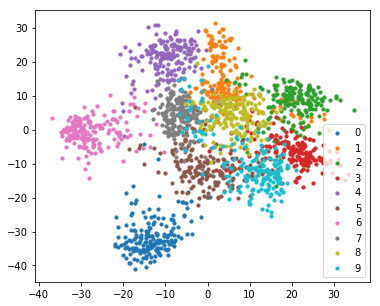

In [52]:
""" Regressed Data """
X_2d = np.array([tsne_x,tsne_y]).T
y=digits.target
target_ids = range(len(digits.target_names))
plt.figure(figsize=(6, 5))
for i, label in zip(target_ids, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=label,s=10)
plt.legend()
plt.show()

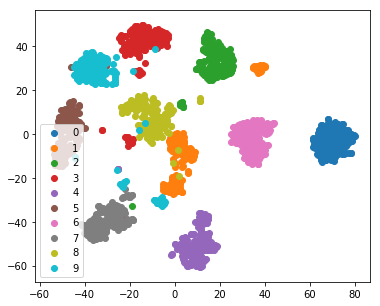

In [53]:
""" Training Data """
X = digits.data
X_2d = tsne.fit_transform(X)
y = digits.target

target_ids = range(len(digits.target_names))
plt.figure(figsize=(6, 5))
for i, label in zip(target_ids, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=label,s=10)
plt.legend()
plt.show()

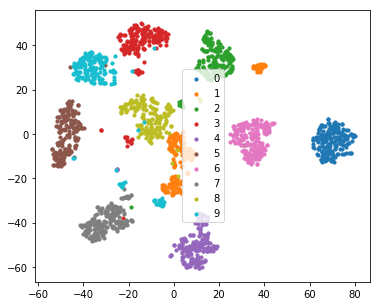

In [76]:
""" Training Data """
X = digits.data
X_2d = tsne.fit_transform(X)
y = digits.target

target_ids = range(len(digits.target_names))
plt.figure(figsize=(6, 5))
for i, label in zip(target_ids, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=label,s=10)
plt.legend()
plt.show()

/Users/Dan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1797 but corresponding boolean dimension is 500
  """Entry point for launching an IPython kernel.


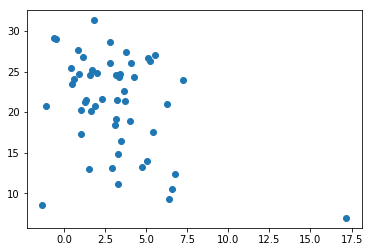

In [50]:
plt.scatter(X_2d[y==1,0],X_2d[y==1,1])
plt.show()

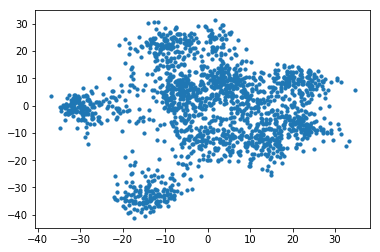

In [48]:
plt.scatter(tsne_x,tsne_y,s=10)
plt.show()